# <center> Trabajo Final </center>

##  <center> Curso de Especialización en Inteligencia Artificial </center>

## <center> Visión por Computadora II </center>


### Autores: 
**- Acerbo, Agustín**<br>
**- Paganini, Rodolfo**<br>
**- Torti, Maximiliano**


### Resumen:

<p style='text-align: justify;'>
    El presente trabajo tiene como objetivo aplicar los conocimientos adquiridos durante el cursado de "Visión por Computadora II" de la Carrera de Especialización en Inteligencia Artificial. Para ello se plantea obtener un algoritmo capaz de localizar y clasificar distintas fallas superficiales en laminas de acero.
</p>

El dataset se obtuvo de la [competencia de Kaggle "Severstal Steel Defect Detection"](https://www.kaggle.com/c/severstal-steel-defect-detection/overview).

A continuación se realiza un analisis exploratorio inicial del dataset.

## Librerias utilizadas:

In [1]:
import os
import csv
import json
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import pickle as pkl
import tensorflow as tf
from sklearn import model_selection
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization, Dense, Add, ReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model

%matplotlib inline

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("csv",csv.__version__),
    ("json",json.__version__),
    ("Seaborn",sns.__version__),
    ("TeensorFlow",tf.__version__),
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
    ("Seaborn",sns.__version__),
    ("Open CV",cv.__version__)
]))

csv:1.0
json:2.0.9
Seaborn:0.11.1
TeensorFlow:2.6.0
Numpy:1.19.5
Pandas:1.1.5
Seaborn:0.11.1
Open CV:4.1.2



## Check TF GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## 1. Análisis exploratorio inicial

### Path del dataset
<p style='text-align: justify;'>
    El dataset con el que trabajaremos está compuesto por una carpeta llamada "train_images", que contiene las imágenes para el entrenamiento de nuestro algoritmo, y un archivo llamado "train.csv", que enlista las imágenes de la carpeta mencionada que contienen alguna falla. Este archivo detalla el ID de la falla y describe los píxeles donde se encuentra dicha falla.
    </p>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/severstal-steel-defect-detection.zip') as myzip:
    myzip.extractall()

In [6]:
csv_path = './train.csv'
train_path = './train_images/'

### train_images

#### Indice de imagenes

<p style='text-align: justify;'>
    En la variable "archivos" generamos un listado de nombres de todas las imagenes.
    </p>

In [7]:
archivos = os.listdir(train_path)
print(f"Cantidad de imágenes: {len(archivos)}")

Cantidad de imágenes: 12568


### train.csv

#### Lectura del archivo

In [8]:
train_csv = pd.read_csv(csv_path)

#### Visualizacion de las primeras 5 filas del archivo

<p style='text-align: justify;'>
    A continuación podemos ver el archivos train.csv contiene una tabla de tres columnas. La primera de ellas contiene el ID de la imagen, la segunda el ID de la clase de falla y por ultimo se encuentran codificados los pixeles que forman parte de dicha falla.
    </p>

In [9]:
train_csv.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


#### Analisis de las etiquetas

<p style='text-align: justify;'>
    Como mencionamos anteriormente nuestro dataset contiene 3 columnas, a través del comando DataFrame.info() de la libreria Pandas, vemos que tenemos 7095 etiquetas. Esto quiere decir que tenemos 7095 fallas etiquetadas en las 12568 imagenes que tenemos. Realizando un análisis más profundo podemos ver las fallas etiquetadas se encuentran repartidas en 6666 imagenes de nuestro dataset.
    </p>

In [10]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [11]:
print(f"Imágenes con fallas: {len(np.unique(train_csv.ImageId))}")
print(f"Clases de fallas: {len(np.unique(train_csv.ClassId))}")
print(f"Fallas etiquetadas: {len(train_csv.ImageId)}")

Imágenes con fallas: 6666
Clases de fallas: 4
Fallas etiquetadas: 7095


<p style='text-align: justify;'>
    Se crea el Data Frame "fallas" que contiene dos columnas. Una de ellas contiene el ID de las imágenes y la otra la cantidad de fallas que se detectaron en dicha imagen. Esto nos ayuda a ver cuántas tipos de fallas se presentan en cada imagen.
    </p>

In [12]:
fallas = pd.DataFrame(columns = ['ImageId', 'Cantidad de Fallas'])
for i, arch in enumerate(archivos):
    fallas.loc[i] = [arch] + [len(list(train_csv[train_csv.eq(arch).any(1)].ImageId))]

fallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12568 entries, 0 to 12567
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ImageId             12568 non-null  object
 1   Cantidad de Fallas  12568 non-null  object
dtypes: object(2)
memory usage: 294.6+ KB


In [13]:
# Se buscan aquellas imagenes que poseen 3 fallas
fallas[fallas.eq(3).any(1)].ImageId

554     db4867ee8.jpg
6805    ef24da2ba.jpg
Name: ImageId, dtype: object

In [14]:
fallas.head()

,ImageId,Cantidad de Fallas
0,9d64b3372.jpg,1
1,aa218783a.jpg,1
2,744c6de01.jpg,1
3,21318dbb2.jpg,0
4,c048dbdc5.jpg,1


Cantidades por Fallas:
Imágenes con 0 fallas: 5902 -> 46.96053469127944%
Imágenes con 1 fallas: 6239 -> 49.64194780394653%
Imágenes con 2 fallas: 425 -> 3.3816040738383197%
Imágenes con 3 fallas: 2 -> 0.015913430935709738%


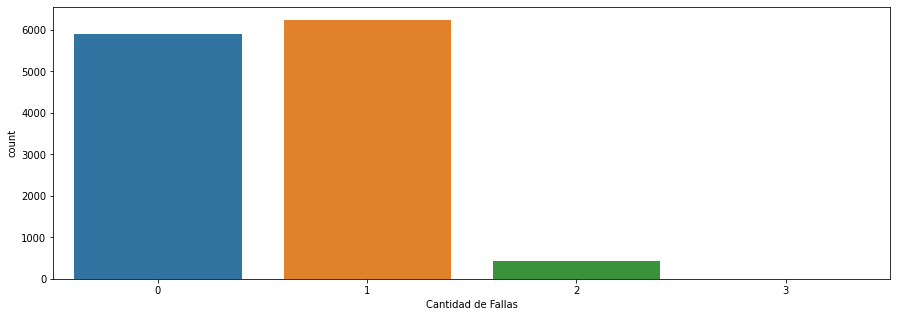

In [15]:
fig,axes = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='Cantidad de Fallas', data=fallas)

print("Cantidades por Fallas:")
for i in range(fallas['Cantidad de Fallas'].nunique()):
    print(f"Imágenes con {i} fallas: {np.sum(fallas['Cantidad de Fallas'] == i)} -> {np.sum(fallas['Cantidad de Fallas'] == i)*100/fallas['Cantidad de Fallas'].count()}%")

<p style='text-align: justify;'>
    Finalmente, se analiza el balance de los ID de fallas que tenemos en el dataset. Vemos un claro desbalance  debido a una gran cantidad de fallas de la falla de tipo 3 en comparación con el resto de los tipos.
    </p>

In [16]:
print(f"Falla tipo 1: {np.sum(train_csv.ClassId==1)}")
print(f"Falla tipo 2: {np.sum(train_csv.ClassId==2)}")
print(f"Falla tipo 3: {np.sum(train_csv.ClassId==3)}")
print(f"Falla tipo 4: {np.sum(train_csv.ClassId==4)}")

Falla tipo 1: 897
Falla tipo 2: 247
Falla tipo 3: 5150
Falla tipo 4: 801


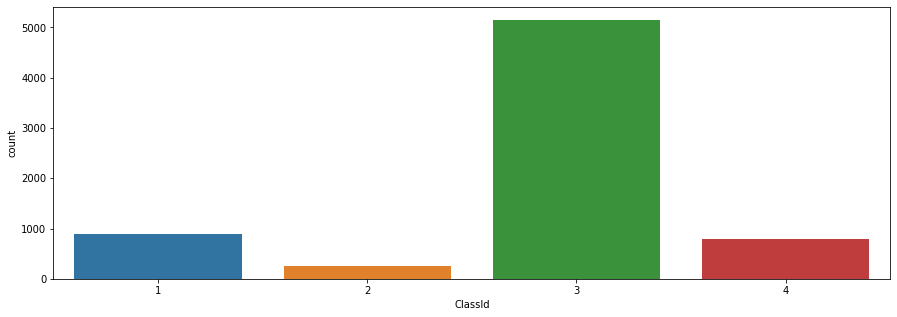

In [17]:
fig,axes = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='ClassId', data=train_csv)

### Conclusiones

<p style='text-align: justify;'>
    En resúmen, se tiene un dataset con 12568 imágenes, donde el 53% de ellas (6666 imagenes) poseen una o más fallas. Estas fallas se pueden clasificar en 4 grupos según el ID de su etiqueta.
    
Por otro lado, en estas 6666 imagenes se encuentran etiquetadas 7095 fallas con un claro desbalance, dado que el 73% de las fallas son de tipo 3.
    
En el desarrollo de nuestro algoritmo debemos tener en cuenta este desbalance entre los tipos de fallas.

#### Visualización de imagenes

<p style='text-align: justify;'>
    Se muestran las primeras 5 imágenes del archivo train.csv:
    </p>

ID de la imagen: 0002cc93b.jpg
Tamaño de la imagen: (256, 1600, 3)


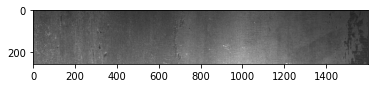

ID de la imagen: 0007a71bf.jpg
Tamaño de la imagen: (256, 1600, 3)


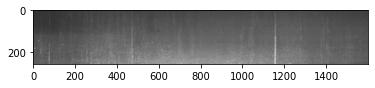

ID de la imagen: 000a4bcdd.jpg
Tamaño de la imagen: (256, 1600, 3)


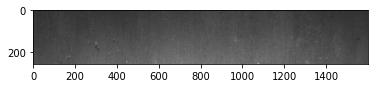

ID de la imagen: 000f6bf48.jpg
Tamaño de la imagen: (256, 1600, 3)


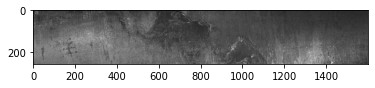

ID de la imagen: 0014fce06.jpg
Tamaño de la imagen: (256, 1600, 3)


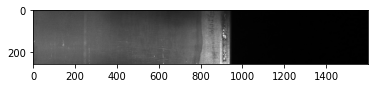

In [18]:
for i, imgid in enumerate(train_csv.ImageId):
    print(f"ID de la imagen: {imgid}")
    img = cv.imread(train_path + '/' + imgid)
    imgRGB = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    print(f"Tamaño de la imagen: {img.shape}")
    plt.imshow(imgRGB)
    plt.show()
    if i > 3:
        break

Se observa que el tamaño de las imágenes es de 1600 x 256 y se encuentran grabadas en RGB, aunque a simple vista parecen estar en escala de grises.

In [19]:
n_w = 1600
n_h = 256

## Ingeniería de Features
<p style='text-align: justify;'>
     Para el entrenamiento del algoritmo se comenzó con la creación de un dataset mejor balanceado, que contuviera todas las muestras con fallas y un cierto número de muestras sin defectos.
</p>

### Creación del dataset
<p style='text-align: justify;'>
     En las variables 'defective_img' y 'nondefective_img' guardamos los nombres de los archivos de imagenes con fallas etiquetadas y sin fallas respectivamente.
</p>

In [20]:
defective_csv = pd.read_csv(csv_path)
defective_img = [value for value in os.listdir(train_path) if value in list(defective_csv['ImageId'])]
nondefective_img = [value for value in os.listdir(train_path) if value not in list(defective_csv['ImageId'])]

print(f"Muestras con fallas etiquetadas: {len(defective_img)}")
print(f"Muestras sin fallas etiquetadas: {len(nondefective_img)}")

Muestras con fallas etiquetadas: 6666
Muestras sin fallas etiquetadas: 5902


<p style='text-align: justify;'>
    Con estas dos variables creamos el dataset con todas las imágenes con fallas etiquetadas y adicionamos 666 imágenes sin falla.
</p>

In [21]:
idx_aux= np.random.permutation(len(nondefective_img))[0: int(len(defective_img)*0.1)-1]
dataset_img = defective_img + [nondefective_img[value] for value in idx_aux]

print(f'Cantidad de imágenes en nuestro dataset: {len(dataset_img)}')

Cantidad de imágenes en nuestro dataset: 7331


### Separación en Train, Validation y Test

In [22]:
x_train, x_test = model_selection.train_test_split( dataset_img, test_size=0.1, random_state=5)
x_train, x_valid = model_selection.train_test_split( x_train, test_size=0.1, random_state=5)

### Decodificación de región de falla y creación de máscara

<p style='text-align: justify;'>
    La siguiente función 'decode_pixels' recibe una lista que contiene la codificación de los píxeles donde se encuentra la falla en determinada imagen y devuelve el listado de píxeles que deben ser incluidos en la máscara para identificar la posición de la falla. Esta información es extraída del archivo train.csv, de la columna 'EncodedPixels'. La información en cuestión está codificada de modo que consiste en una serie de números separados por espacio, y su significado se va alternando en pixel inicial y cantidad de píxeles sucesivos que formarán parte de la máscara. Por ejemplo, si la función recibe "1 3 10 5", implica que que los pixeles 1, 2, 3, 10, 11, 12, 13, 14 deben estar incluídos en la máscara. 
</p>

In [23]:
def decode_pixels(pixels_str):
    """
    This function receives a list which contains the pixels as a space-separated code.
    For example, '1 3 10 5' implies pixels 1, 2, 3, 10, 11, 12, 13, 14 are to be included in the mask
    """
    
    pixels_encoded_list = pixels_str.split(' ')
    pixels_list = []
    for i in range(0, len(pixels_encoded_list), 2):
        # Add to the pixels list all the pixels encoded by the 2 digits
        pixels_list += range(
            int(pixels_encoded_list[i]) - 1,
            int(pixels_encoded_list[i]) + int(pixels_encoded_list[i + 1]) - 1,
        )
        
    # Return the decoded list    
    return pixels_list

<p style='text-align: justify;'>
    La función 'make_mask' que se muestra a continuación se diseñó para obtener las máscaras de las imágenes que se utilizarán en el entrenamiento de los modelos. Esta función recibe el id de una imagen y la variable n_class.
    
Si n_class = 1, se crea una máscara que contiene todas las fallas de la imagen sin importar que sean de distinto tipo.
    
Si n_class = 4, se genera una máscara para cada tipo de falla devolviendo así un arreglo de 4 máscaras, una por cada tipo de falla.
</p>

In [24]:
def make_mask(ImageId, n_class=1):
    """
    This function creates the mask(s) to train the CNN models.
    It receives the ImageId and the number of classes to analyse.
    
    If n_class == 1, it creates a mask for the image where all the failures in the image apear,
    independently from the failure type.
    """

    y_out=defective_csv[defective_csv['ImageId'].eq(ImageId)]
    
    image_pixels = np.zeros((n_h, n_w,n_class), dtype=np.float32)

    for index, row in y_out.iterrows():

        # Generate the mask of the error type
        mask = np.zeros((n_h * n_w, 1), dtype=np.float32)
        mask[decode_pixels(row['EncodedPixels'])] = 1
        mask = mask.reshape(n_w, n_h)
        mask = mask.T
    
        # Update channel of the given error
        if n_class == 1:
            image_pixels [:,:,0] = np.logical_or(image_pixels [:,:,0],mask)
        else:
            image_pixels [:,:,int(row['ClassId'])-1] = np.logical_or(image_pixels [:,:,int(row['ClassId'])-1],mask)
            
    return image_pixels

### Funciones de Data Augmentation

<p style='text-align: justify;'>
    Para la aplicación de data augmentation se crearon tres funciones, flip, rotate y shift, que afectan a las imágenes como expresan sus nombres. La función flip voltea la imagen y su máscara, ya sea horizontal y/o verticalmente según sean sus argumentos. La función rotate rota la imagen y su máscara un determinado ángulo y tiene la posibilidad de reescalarla. Por último, la funcion shift desplaza a la imagen y a su máscara de manera horizontal y/o vertical, según sus argumentos.
</p>

In [34]:
def flip(image, mask , vflip=False, hflip=False):
    '''
    Flip the image
    :param image: image to be processed
    :param vflip: whether to flip the image vertically
    :param hflip: whether to flip the image horizontally
    '''
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv.flip(image, flipCode=c)
        mask = cv.flip(mask, flipCode=c)
    return image, mask

def rotate(image, mask, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv.warpAffine(image,M,(w,h))
    mask = cv.warpAffine(mask,M,(w,h))
    return image, mask
    
def shift(image, mask, px, py):
    w = image.shape[1]
    h = image.shape[0]
    
    img = np.zeros((h,w))
    m = np.zeros((h,w))   
    
    if (py > 0) and (px > 0):
        img[py:, px:] = image[:-py, :-px]
        m[py:, px:] = mask[:-py, :-px]
    elif (py < 0) and (px < 0):
        img[:py, :px] = image[-py:, -px:]
        m[:py, :px] = mask[-py:, -px:]
    elif (py > 0) and (px < 0):
        img[py:, :px] = image[:-py, -px:]
        m[py:, :px] = mask[:-py, -px:]
    elif (py < 0) and (px > 0):
        img[:py, px:] = image[-py:, :-px]
        m[:py, px:] = mask[-py:, :-px]
    
    return img, m

## Data generator

Utilizamos un generador para crear el par imagen - máscara de falla en forma online dada una lista de archivos de imágenes. Este generador resulta de gran utilidad para las etapas de entrenamiento y testeo de los modelos.

**Nota:**

**Por limitaciones en el hardware utilizado para entrenar ( Nvidia GTX 1060 y RTX2060 con 6GB RAM), fue necesario:**

**1- Escalado de las imágenes a 800x128 (mitad de su tamaño original). Para el problema a resolver, este escalado no supone un problema**

**2- Convertir imágenes en escala de grises. Las imágenes ya se encuentran realmente en escala de grises, por lo que podemos ahorrar memoria al hacer la conversión de 3 canales a 1 solo.**

In [68]:
def data_generator(ids, batch_size, n_class = 4, data_augmentation=False):
    Xs = []; ys = []
    
    while True:
        random.shuffle(ids)
        aug_shift = np.random.randint(2, size=len(ids))
        aug_rot = np.random.randint(2, size=len(ids))
        aug_flip = np.random.randint(2, size=len(ids))
        for i, id in enumerate(ids):
            img = cv.imread(train_path + id)
            img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            img = img / 255.
            
            mask = make_mask(id,n_class=n_class)
            
            img=cv.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)))
            mask=cv.resize(mask, (int(mask.shape[1]/2),int(mask.shape[0]/2)))
            
            # Optionally perform data augmentation
            if data_augmentation:
                if aug_shift[i] == 1:
                    img, mask = shift(img, mask,
                                        px=np.random.randint(low = -int(img.shape[1]/10),high = int(img.shape[1]/10)),
                                        py=np.random.randint(low = -int(img.shape[0]/10),high = int(img.shape[0]/10))
                                    )
                if aug_rot[i] == 1:
                    img, mask = rotate(img, mask, angle=np.random.randint(-10,10), scale=1.0 + (random.randint(0,20)/10) )
                if aug_flip[i] == 1:
                    img, mask = flip(img, mask, vflip=True, hflip=False)
                mask = (mask > 0.2) * 1.0

            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield (X, y)

## Metricas Útiles

En segmentación, normalmente las métricas convencionales como el accuracy no son de utilidad, debido a la gran proporción de píxeles de fondo. Se definen entonces las siguientes métricas.

In [27]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice

def dice_coef_nd(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return 2.*intersection, (np.sum(y_true_f)+np.sum(y_pred_f))

def dice_loss(y_true,y_pred):
    return (1 - dice_coef(y_true,y_pred))

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (1 - ((true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)))

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

# Modelos

## Modelo 1: U-Net con salida binaria
<p style='text-align: justify;'>
    Dado que el problema es de segmentación, nos pareció que una arquitectura que podría tener buenos resultados es la U-Net. Es por eso que el primer modelo que entrenamos fue de ese tipo, con una salida sigmóidea, de modo que clasificara falla contra fondo.

Clasificar de esta manera nos daría una idea de si la arquitectura sirve, y al mismo tiempo comenzaríamos con un problema de dos clases con un buen balance. Si el modelo fallara en este caso, ya sabríamos que no tendría sentido usarlo para el problema de clasificar los distintos tipos de falla.
    </p>

In [28]:
def build_unet(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Mitad
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_unet = Input((128, 800, 1))
output_unet = build_unet(input_unet, 16)


In [29]:
model_unet = Model(input_unet, output_unet)

In [30]:
model_unet.compile(loss=dice_loss, optimizer="adam", metrics=["accuracy",dice_coef,iou_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 800, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 800, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 400, 16)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

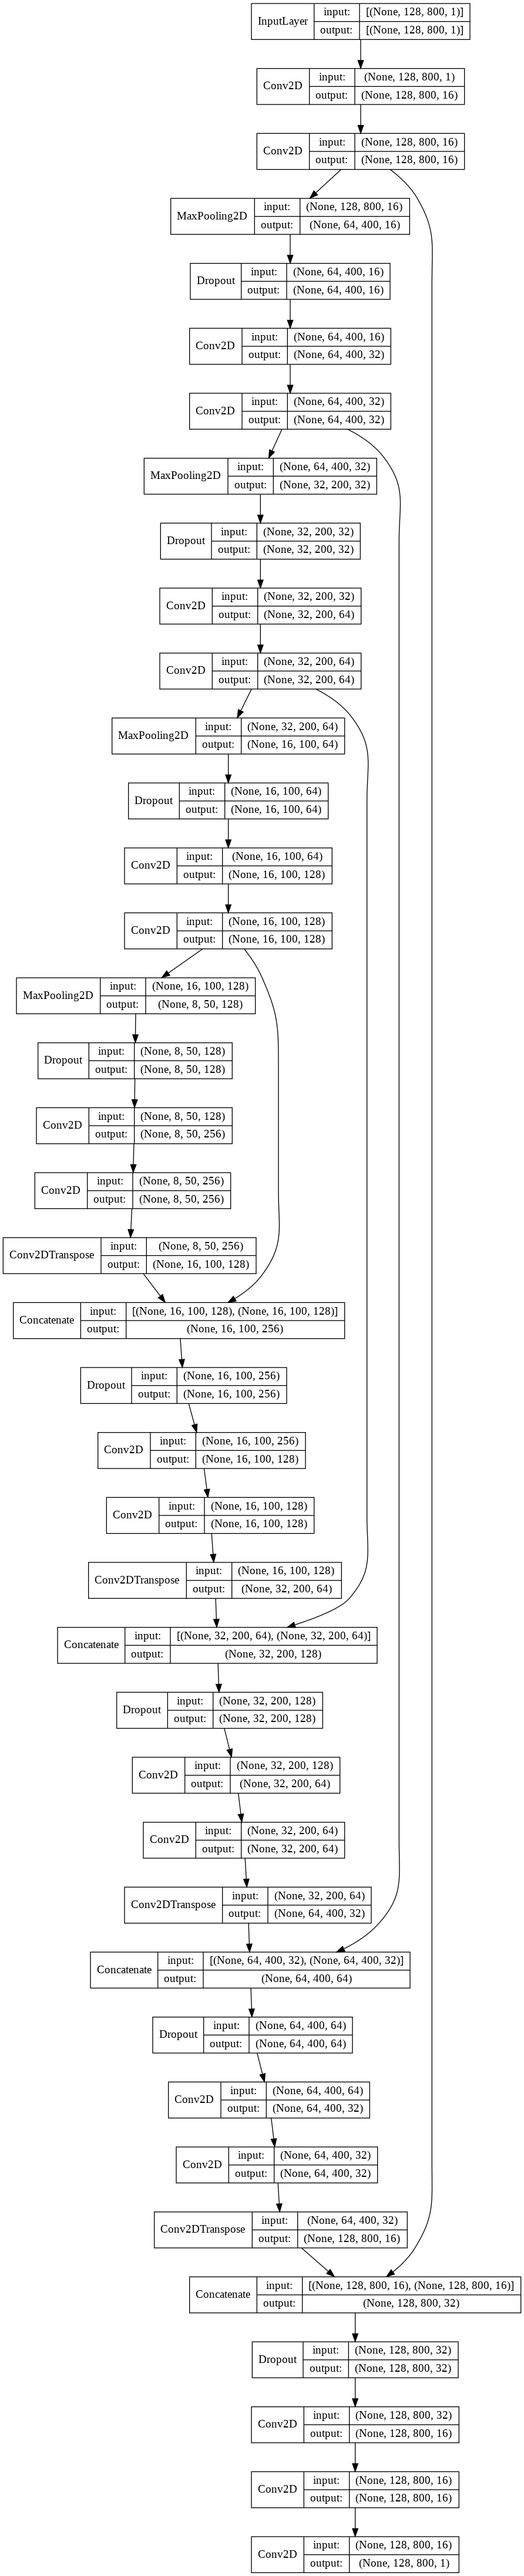

In [31]:
plot_model(model_unet, show_shapes=True, show_layer_names=False)

Este modelo fue entrenado por aproximadamente 50 epochs. A continuación, cargamos los pesos del mejor modelo conseguido previamente y hacemos un fit por 1 sola epoch a modo de ejemplo.

In [69]:
model_unet.load_weights('./weights/Unet/Unet')

In [70]:
epochs = 1
batch_size = 16

train_generator = data_generator(x_train, batch_size, 1)
validation_generator = data_generator(x_valid, batch_size, 1)

train_steps_per_epoch=int(len(x_train)/batch_size)
validation_steps_per_epoch=int(len(x_valid)/batch_size)

history = model_unet.fit_generator(generator=train_generator,
                                   steps_per_epoch=train_steps_per_epoch,
                                   epochs=epochs,
                                   validation_data = validation_generator,
                                   validation_steps = validation_steps_per_epoch
                                  )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


371/371 [==============================] - 118s 314ms/step - loss: 0.3709 - accuracy: 0.9586 - dice_coef: 0.6291 - iou_coef: 0.4649 - val_loss: 0.3222 - val_accuracy: 0.9649 - val_dice_coef: 0.6778 - val_iou_coef: 0.5165


## Modelo 2: ResUnet - Inception

Dado que en el modelo anterior las métricas nos mostraron que teníamos altos el bias y la varianza, nos pareció sensato aumentar la complejidad del modelo. Lo intentamos convirtiendo los bloques convolucionales de la U-Net en bloques residuales, así como incluyendo un bloque inception en la mitad de la red.

In [37]:
def inception_block(prevlayer, a, b):
    
    conva = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    conva = Conv2D(b, (3, 3), activation=None, padding='same')(conva)
    conva = BatchNormalization()(conva)
    conva = ReLU()(conva)
    
    convb = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    convb = Conv2D(b, (5, 5), activation=None, padding='same')(convb)
    convb = BatchNormalization()(convb)
    convb = ReLU()(convb)

    convc = Conv2D(b, (1, 1), activation=None, padding='same')(prevlayer)
    convc = BatchNormalization()(convc)
    convc = ReLU()(convc)
        
    convd = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding= 'same')(prevlayer)
    convd = Conv2D(b, (1, 1), activation=None, padding='same')(convd)
    convd = BatchNormalization()(convd)
    convd = ReLU()(convd)
        
    up = concatenate([conva, convb, convc, convd])
    return up

In [38]:
def residual_block (input_layer, neurons):
    
    conv1 = Conv2D(neurons , (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1_skip = Conv2D(neurons, 1, 1, activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1_skip = BatchNormalization()(conv1_skip)
    
    added1 = Add()([conv1_skip, conv1])
    relu1 = ReLU()(added1)
    
    return relu1

In [71]:
def build_resunet(input_layer, start_neurons):
    
    conv1 = residual_block(input_layer,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = residual_block(pool1,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = residual_block(pool2,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = residual_block(pool3,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Mitad
    convm = inception_block (pool4, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)

    deconv4 = Conv2DTranspose(start_neurons * 8, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)

    deconv3 = Conv2DTranspose(start_neurons * 4, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)

    deconv2 = Conv2DTranspose(start_neurons * 2, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    return output_layer

input_resunet = Input((128, 800, 1))
output_resunet = build_resunet(input_resunet, 8)

model_resunet = Model(input_resunet, output_resunet)

In [72]:
model_resunet.compile(loss=dice_loss, optimizer="adam", metrics=["accuracy",dice_coef,iou_coef])
model_resunet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 800, 1) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 800, 8)  208         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 128, 800, 8)  32          conv2d_144[0][0]                 
__________________________________________________________________________________________________
re_lu_88 (ReLU)                 (None, 128, 800, 8)  0           batch_normalization_112[0][0]    
____________________________________________________________________________________________

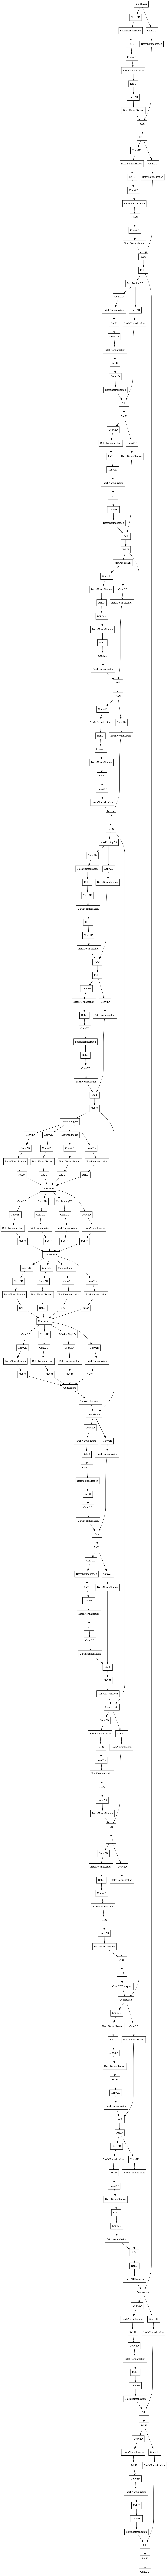

In [73]:
plot_model(model_resunet, show_shapes=False, show_layer_names=False)

In [74]:
model_resunet.load_weights('./weights/resUnetInceptionV5/resUnetInceptionV5')

In [75]:
history = model_resunet.fit_generator(generator=train_generator,
                                   steps_per_epoch=train_steps_per_epoch,
                                   epochs=epochs,
                                   validation_data = validation_generator,
                                   validation_steps = validation_steps_per_epoch
                                  )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


371/371 [==============================] - 236s 617ms/step - loss: 0.2923 - accuracy: 0.9674 - dice_coef: 0.7077 - iou_coef: 0.5519 - val_loss: 0.2715 - val_accuracy: 0.9718 - val_dice_coef: 0.7285 - val_iou_coef: 0.5764


## Modelo 3: ResUnet - Inception con 4 salidas sigmoid para detectar los tipos de error independientemente

### Creación de dataset balanceado en tipos de fallas

<p style='text-align: justify;'>
    En el entrenamiento del algoritmo nos encontramos con grandes errores al reconocer fallas del tipo 1, 2 y 4, lo cual adjudicamos al desbalance entre los distintos tipos de falla. Dada la gran cantidad de muestras con fallas de tipo 3, los pesos aprendidos se vieron sesgados por dicho desbalance.
    
Para subsanar esta problemática se decidió crear un dataset más balanceado.
</p>

In [76]:
# Path dataset reducido
csv_reducido = r"/train_reducido.csv"

<p style='text-align: justify;'>
    Como ya hemos mencionado el dataset cuenta con 897 etiquetas de la falla tipo 1, 247 etiquetas de la falla tipo 2, 5150 etiquetas de la falla tipo 3 y finalmente 801 etiquetas de falla de tipo 4. Nuestro objetivo aqui será crear a partir de este set de entrenamiento uno más pequeño con un numero más balanceado, para ello quitaremos muestras del tipo 3. Como contrapartida obtendremos un set más pequeño.
</p>

<p style='text-align: justify;'>
    Creamos una copia del dataset original quitando todas aquellas muestras que sean de falla tipo 3.
</p>

In [77]:
train_reducido = train_csv[train_csv['ClassId']!=3].copy()
train_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 7086
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        1945 non-null   object
 1   ClassId        1945 non-null   int64 
 2   EncodedPixels  1945 non-null   object
dtypes: int64(1), object(2)
memory usage: 60.8+ KB


<p style='text-align: justify;'>
    Creamos una copia del dataset original solo con las fallas tipo 3.
</p>

In [78]:
type_3 = train_csv[train_csv['ClassId']==3].copy()
type_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5150 entries, 1 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        5150 non-null   object
 1   ClassId        5150 non-null   int64 
 2   EncodedPixels  5150 non-null   object
dtypes: int64(1), object(2)
memory usage: 160.9+ KB


<p style='text-align: justify;'>
    A continuación concatenamos al dataset 'train_reducido' 900 muestras con fallas de tipo 3:
</p>

In [79]:
train_reducido = pd.concat([train_reducido, type_3[:900]])
train_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845 entries, 0 to 1265
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        2845 non-null   object
 1   ClassId        2845 non-null   int64 
 2   EncodedPixels  2845 non-null   object
dtypes: int64(1), object(2)
memory usage: 88.9+ KB


<p style='text-align: justify;'>
    Finalmente guardamos el dataset reducido en formato .csv
</p>

In [80]:
train_reducido.to_csv(csv_reducido, index=False)

### Definición del modelo

In [81]:
def build_resunet_multiclass(input_layer, start_neurons):
    
    uconv1 = residual_block(input_layer,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    output_layer1 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    uconv2 = residual_block(input_layer,start_neurons * 1)
    uconv2 = residual_block(uconv2,start_neurons * 1)
    output_layer2 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv2)
    
    uconv3 = residual_block(input_layer,start_neurons * 1)
    uconv3 = residual_block(uconv3,start_neurons * 1)
    output_layer3 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv3)
    
    uconv4 = residual_block(input_layer,start_neurons * 1)
    uconv4 = residual_block(uconv4,start_neurons * 1)
    output_layer4 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv4)
    
    uconvf = concatenate([output_layer1, output_layer2, output_layer3, output_layer4])
    
    return uconvf

output_resunet_multiclass = build_resunet_multiclass(model_resunet.layers[-4].output,4)

model_resunet_multiclass = Model(model_resunet.layers[0].input, output_resunet_multiclass)

In [82]:
model_resunet_multiclass.load_weights('./weights/resUnetInception4Sigmoid_vFinal/resUnetInception4Sigmoid_vFinal')

In [83]:
optimizer = Adam()
model_resunet_multiclass.compile(optimizer, dice_loss, metrics=[dice_coef])

In [84]:
model_resunet_multiclass.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 800, 1) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 800, 8)  208         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 128, 800, 8)  32          conv2d_144[0][0]                 
__________________________________________________________________________________________________
re_lu_88 (ReLU)                 (None, 128, 800, 8)  0           batch_normalization_112[0][0]    
____________________________________________________________________________________________

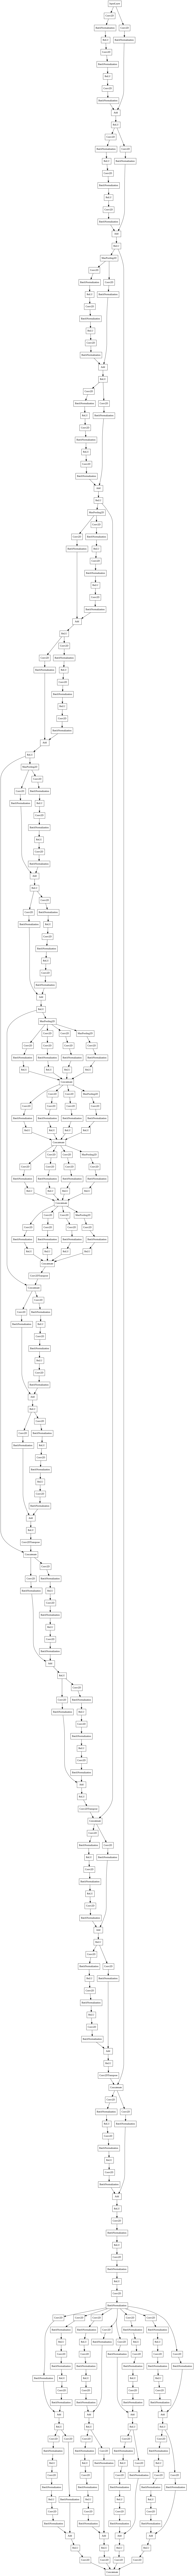

In [85]:
plot_model(model_resunet_multiclass, show_shapes=False, show_layer_names=False)

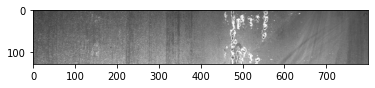

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


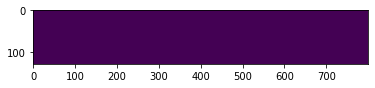

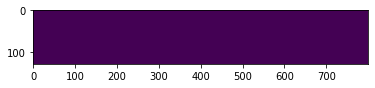

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


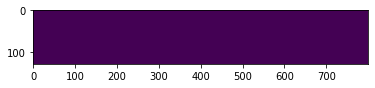

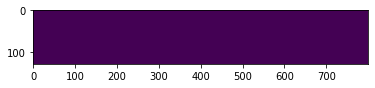

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


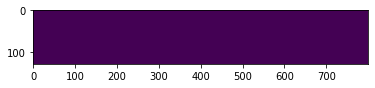

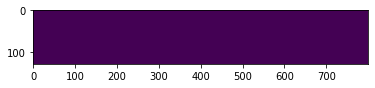

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


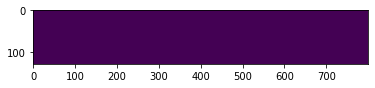

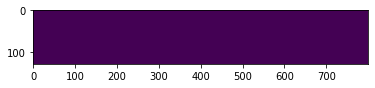

Mean IOU: 1.0
Mean DICE: 1.0
Keras-IOU: 1.0


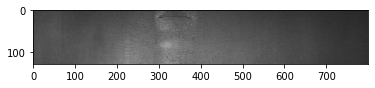

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


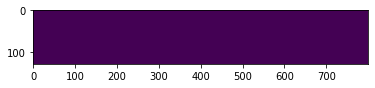

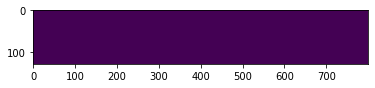

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


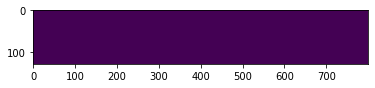

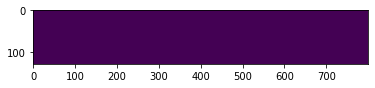

Falla tipo: 3 - IOU: 0.0008756567258387804 - DICE: 0.0008756567258387804


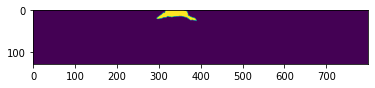

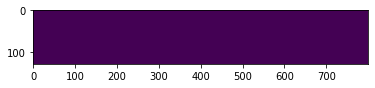

Falla tipo: 4 - IOU: 0.0013418432790786028 - DICE: 0.0013418432790786028


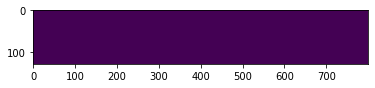

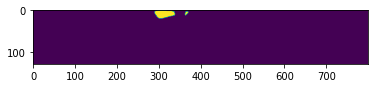

Mean IOU: 0.5005543828010559
Mean DICE: 0.5005543828010559
Keras-IOU: 0.49867066740989685


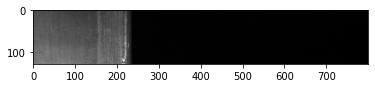

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


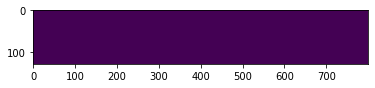

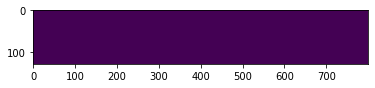

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


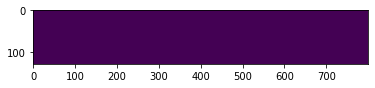

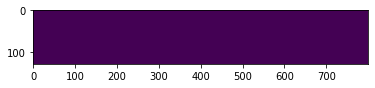

Falla tipo: 3 - IOU: 0.004662004765123129 - DICE: 0.004662004765123129


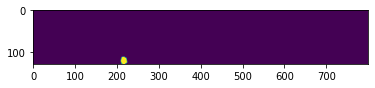

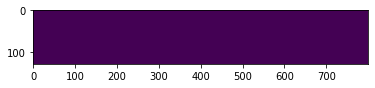

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


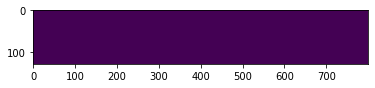

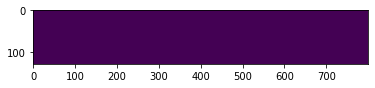

Mean IOU: 0.751165509223938
Mean DICE: 0.751165509223938
Keras-IOU: 0.4997583031654358


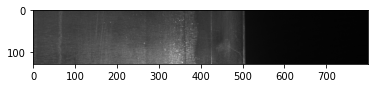

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


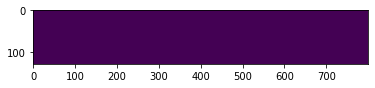

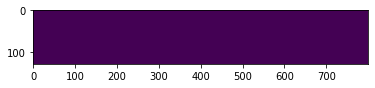

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


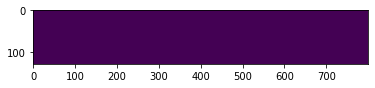

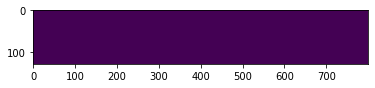

Falla tipo: 3 - IOU: 0.007112663239240646 - DICE: 0.013710683211684227


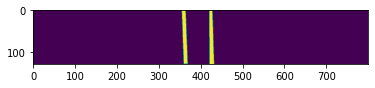

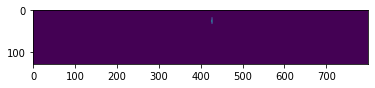

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


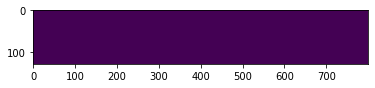

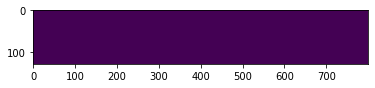

Mean IOU: 0.7517781853675842
Mean DICE: 0.7534276843070984
Keras-IOU: 0.4972790479660034


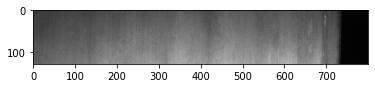

Falla tipo: 1 - IOU: 0.0044843051582574844 - DICE: 0.0044843051582574844


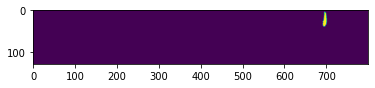

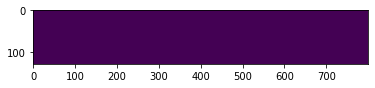

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


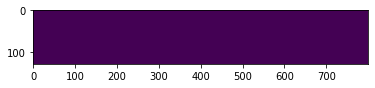

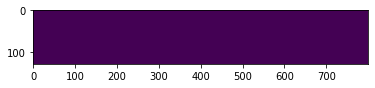

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


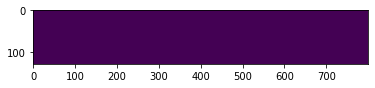

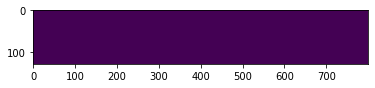

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


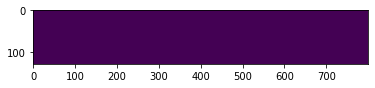

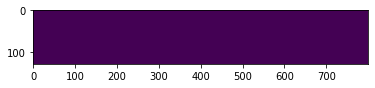

Mean IOU: 0.7511210441589355
Mean DICE: 0.7511210441589355
Keras-IOU: 0.4997607469558716


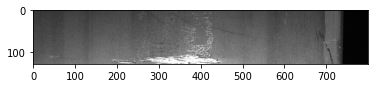

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


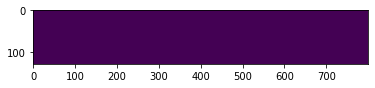

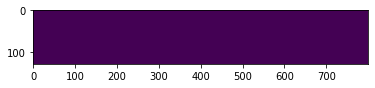

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


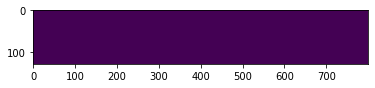

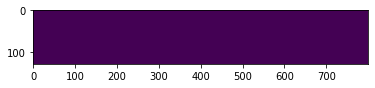

Falla tipo: 3 - IOU: 0.4333837926387787 - DICE: 0.6046748161315918


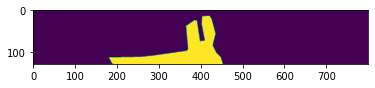

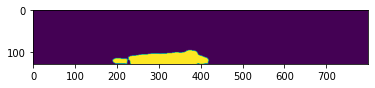

Falla tipo: 4 - IOU: 0.002473545027896762 - DICE: 0.002473545027896762


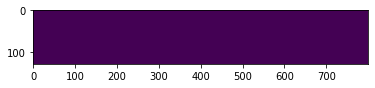

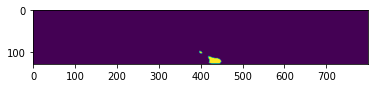

Mean IOU: 0.6089643239974976
Mean DICE: 0.6517871022224426
Keras-IOU: 0.5452848076820374


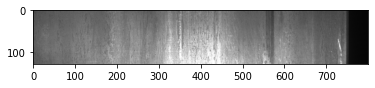

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


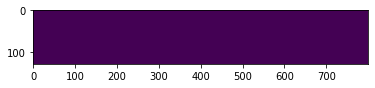

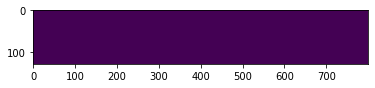

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


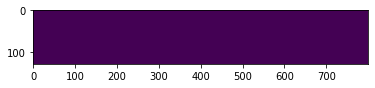

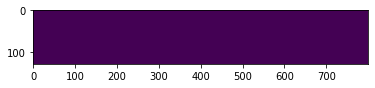

Falla tipo: 3 - IOU: 0.18751943111419678 - DICE: 0.315701425075531


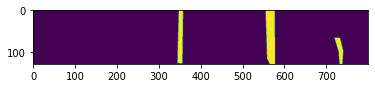

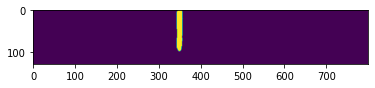

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


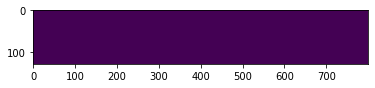

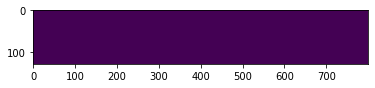

Mean IOU: 0.7968798875808716
Mean DICE: 0.828925371170044
Keras-IOU: 0.5725258588790894


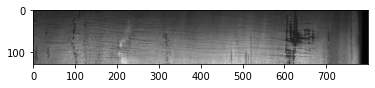

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


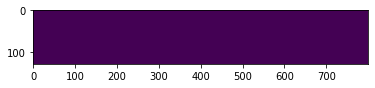

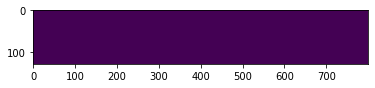

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


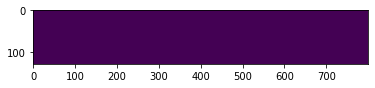

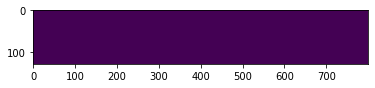

Falla tipo: 3 - IOU: 0.2814539670944214 - DICE: 0.4392545819282532


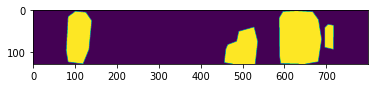

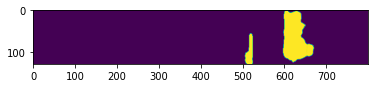

Falla tipo: 4 - IOU: 0.0007180494139902294 - DICE: 0.0007180494139902294


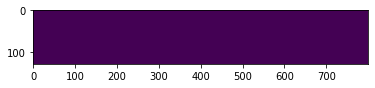

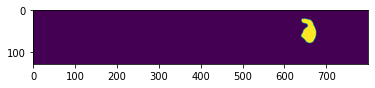

Mean IOU: 0.5705430507659912
Mean DICE: 0.6099931597709656
Keras-IOU: 0.5033533573150635


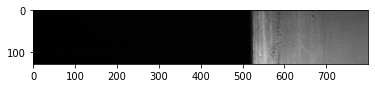

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


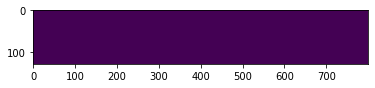

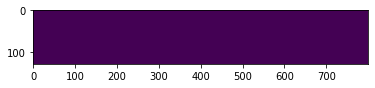

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


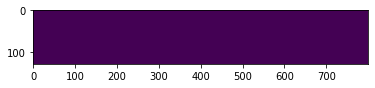

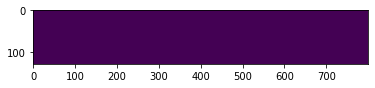

Falla tipo: 3 - IOU: 0.0011580776190385222 - DICE: 0.0011580776190385222


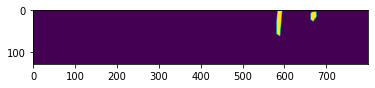

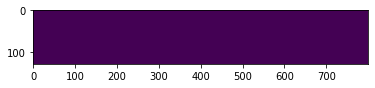

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


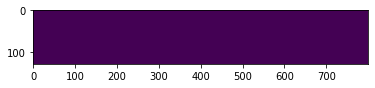

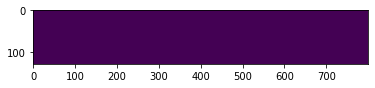

Mean IOU: 0.7502894997596741
Mean DICE: 0.7502894997596741
Keras-IOU: 0.4990234375


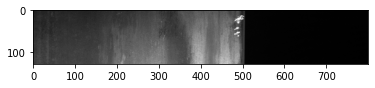

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


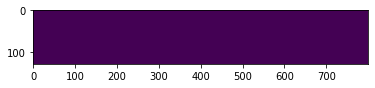

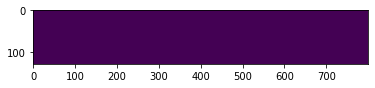

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


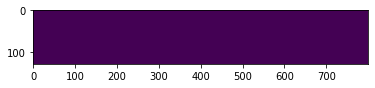

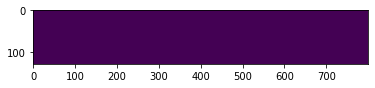

Falla tipo: 3 - IOU: 0.7395739555358887 - DICE: 0.8502268195152283


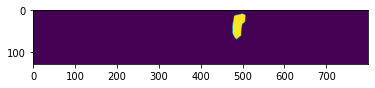

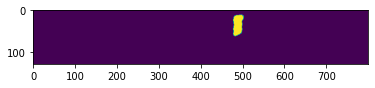

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


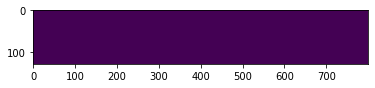

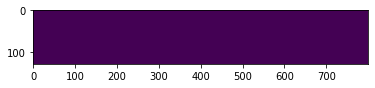

Mean IOU: 0.9348934888839722
Mean DICE: 0.9625567197799683
Keras-IOU: 0.4985119700431824

Mean IOU Total: 0.7416189908981323
Mean DICE Total: 0.7559820413589478
Keras-IOU Total: 0.561416819691658


In [98]:
test_generator = data_generator(x_test,batch_size=1, n_class = 4)

iou_total = 0
iou_keras_total = 0
dice_total = 0

for i in range(10):
    data_test = next(test_generator)
    prediction = model_resunet_multiclass.predict(data_test[0])
    plt.imshow(data_test[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    iou = 0
    dice_1 = 0

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        
        y_pred = (y_pred[:, :] > 0.5) * y_pred
        print(f"Falla tipo: {j+1} - "
              f"IOU: {iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)} - "
              f"DICE: {dice_coef(y_true, y_pred)}")
        iou += iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
        dice_1 += dice_coef(y_true, y_pred)
        plt.imshow(y_true)
        plt.show()
        plt.imshow(y_pred)
        plt.show()
        
        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
        
    print(f"Mean IOU: {iou/4}")
    print(f"Mean DICE: {dice_1/4}")
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()
    iou_keras = m.result().numpy()
    print(f"Keras-IOU: {iou_keras}")
    
    iou_total += iou/4
    dice_total += dice_1/4
    iou_keras_total += iou_keras
    
print()
print(f"Mean IOU Total: {iou_total/10}")
print(f"Mean DICE Total: {dice_total/10}")
print(f"Keras-IOU Total: {iou_keras_total/10}")

### Testeo de modelo
<p style='text-align: justify;'>
    
</p>


In [103]:
test_generator = data_generator(x_test,batch_size=1)

iou_all = np.zeros((len(x_test), 4))
dice_all = np.zeros((len(x_test), 4))

iou_keras_total = 0

for i in range(len(x_test)):
    data_test = next(test_generator)
    prediction = model_resunet_multiclass.predict(data_test[0])

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        y_pred = (y_pred[:, :] > 0.5) * y_pred

        iou_all[i, j] = iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
        dice_all[i, j] = dice_coef(y_true, y_pred).numpy()

        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()

    iou_keras_total += m.result().numpy()

print(f"Mean IOU Total: {np.average(iou_all)}")
print(f"Mean DICE Total: {np.average(dice_all)}")
print(f"Keras-IOU Total: {iou_keras_total/len(x_test)}")

print('\nEstadísticas por tipo de falla:\n')
for i in range(iou_all.shape[1]):
    print('- Falla de tipo {}: IOU {}\t DICE {}'.format(
        i + 1, np.average(iou_all[:, i]), np.average(dice_all[:, i])))


Mean IOU Total: 0.7873204160665361
Mean DICE Total: 0.8070928907908166
Keras-IOU Total: 0.653602279296363

Estadísticas por tipo de falla:

- Falla de tipo 1: IOU 0.8884766440750471	 DICE 0.8884766440750471
- Falla de tipo 2: IOU 0.971450127612061	 DICE 0.971450127612061
- Falla de tipo 3: IOU 0.5253883982688238	 DICE 0.5923132161765315
- Falla de tipo 4: IOU 0.7639664943102126	 DICE 0.7761315752996266


# Apéndice: Testeo de los 2 modelos iniciales

## Unet

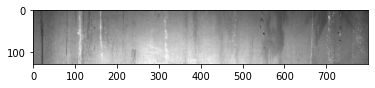

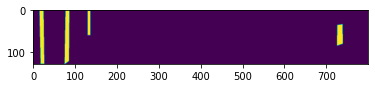

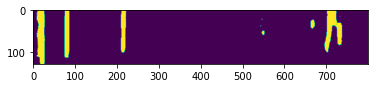

IOU: 0.3783595860004425
DICE: 0.5489561557769775
Keras-IOU: 0.6598309278488159


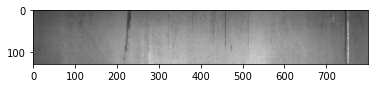

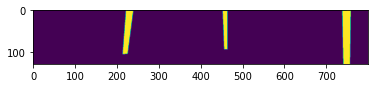

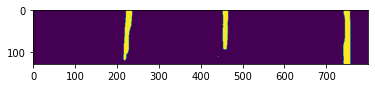

IOU: 0.7826909422874451
DICE: 0.8780871629714966
Keras-IOU: 0.8857964277267456


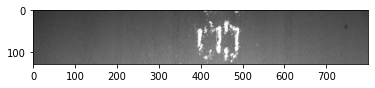

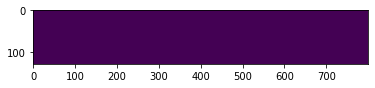

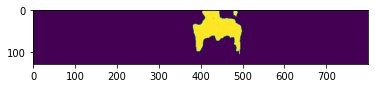

IOU: 0.00015523201727773994
DICE: 0.00015523201727773994
Keras-IOU: 0.46864745020866394

Mean IOU Total: 0.38706859946250916
Mean DICE Total: 0.47573283314704895
Keras-IOU Total: 0.6714249352614085


In [104]:
test_generator = data_generator(x_test,batch_size=1, n_class=1)

iou_total = 0
iou_keras_total = 0
dice_total = 0

n_samples = 3
for i in range(n_samples):
    data_test = next(test_generator)
    prediction = model_unet.predict(data_test[0])
    plt.imshow(data_test[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()

    y_true = data_test[1][0][:,:]
    y_pred = prediction[0][:,:, 0]
    y_pred = (y_pred[:, :] > 0.5) * y_pred

    iou = iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
    dice_1 = dice_coef(y_true, y_pred)
    plt.imshow(y_true)
    plt.show()
    plt.imshow(y_pred)
    plt.show()
        
    print(f"IOU: {iou}")
    print(f"DICE: {dice_1}")
    
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state([y_true], [y_pred]).numpy()
    keras_iou = m.result().numpy()
    print(f"Keras-IOU: {keras_iou}")
    
    iou_total += iou
    dice_total += dice_1
    iou_keras_total += keras_iou
    
print()
print(f"Mean IOU Total: {iou_total/n_samples}")
print(f"Mean DICE Total: {dice_total/n_samples}")
print(f"Keras-IOU Total: {iou_keras_total/n_samples}")

## Res U-Net Inception

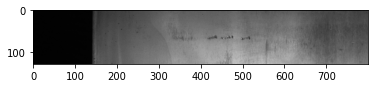

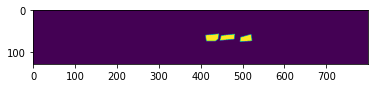

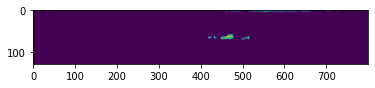

IOU: 0.17246723175048828
DICE: 0.29377391934394836
Keras-IOU: 0.4945996105670929


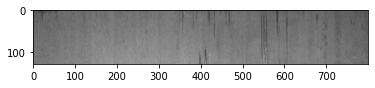

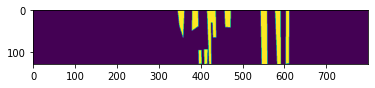

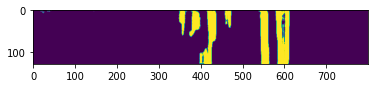

IOU: 0.6689363718032837
DICE: 0.8016214966773987
Keras-IOU: 0.8114489316940308


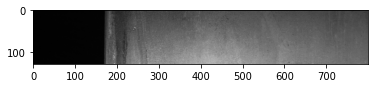

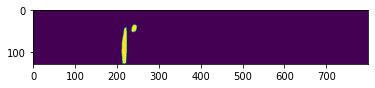

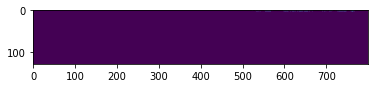

IOU: 0.000910741975530982
DICE: 0.000910741975530982
Keras-IOU: 0.49534180760383606

Mean IOU Total: 0.2807714641094208
Mean DICE Total: 0.365435391664505
Keras-IOU Total: 0.6004634499549866


In [105]:
test_generator = data_generator(x_test,batch_size=1, n_class=1)

iou_total = 0
iou_keras_total = 0
dice_total = 0

n_samples = 3
for i in range(n_samples):
    data_test = next(test_generator)
    prediction = model_resunet.predict(data_test[0])
    plt.imshow(data_test[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()

    y_true = data_test[1][0][:,:]
    y_pred = prediction[0][:,:, 0]
    y_pred = (y_pred[:, :] > 0.5) * y_pred

    iou = iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
    dice_1 = dice_coef(y_true, y_pred)
    plt.imshow(y_true)
    plt.show()
    plt.imshow(y_pred)
    plt.show()
        
    print(f"IOU: {iou}")
    print(f"DICE: {dice_1}")
    
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state([y_true], [y_pred]).numpy()
    keras_iou = m.result().numpy()
    print(f"Keras-IOU: {keras_iou}")
    
    iou_total += iou
    dice_total += dice_1
    iou_keras_total += keras_iou
    
print()
print(f"Mean IOU Total: {iou_total/n_samples}")
print(f"Mean DICE Total: {dice_total/n_samples}")
print(f"Keras-IOU Total: {iou_keras_total/n_samples}")